In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import random
import math
import xgboost as xgb
import matplotlib.pyplot as plt
import geopandas as gpd

from copy import copy
import pickle

### All files available in github repository: https://github.com/eldonlk/CP255-Route_Optimization

# Import Auxiliary Functions

For simplicity and cleanliness, I created a file that holds all our auxiliary functions. This includes the data cleaning and various parts for the genetic algorithm. This includes the initializing a starting generation, predicting and ranking the population, selecting parents, and crossing the parents. You can view the list of auxiliary functions in the folder or in the overview.ipynb

In [2]:
import aux_functions as af

[20:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


## Updates

Most of the functions are the same as the previous overview notebook, but I have made some updates to several parts.

The first update was adding a starting point to the functions. Before, the best order was chosen, meaning the starting point could be at any of the inputted points. However, I realized it did not make sense for actual use. As a result, I added an additional input which is the starting point. All routes will always start from this starting point and the optimal route is then calculated afterwards. To do so I updated my ranking function and final getting the optimal order.

In [3]:
def rank(start_pt, input_pop, orig_pts, datetime):
    hold_df = pd.DataFrame(input_pop)

    total_time_hold = [0] * len(input_pop)

    for i in range(len(input_pop)):
        #concat with starting point as always the first point to start from
        total_time_hold[i] = get_total_time(pd.concat([start_pt, orig_pts.reindex(input_pop[i])], sort = False), datetime)

    # add total time column / fitness
    hold_df['total_time'] = total_time_hold

    # add rank column which gives the highest rank to the combination with the lowest total trip duration
    hold_df['rank'] = len(hold_df) - hold_df['total_time'].rank() + 1

    # add chance column which uses rank to calculate probability of being chosen as a parent
    ##higher fitness means higher chance of breeding
    hold_df['chance'] = hold_df['rank'] * 2 / (len(hold_df) * (len(hold_df) + 1))

    return (hold_df)

# Optimization Function

Below is the final optimization function. It is not included in the auxiliary file as it can be edited depending on how you want the output format to be. This helped during the visulization/dashboard process which I will go into more detail later. Below I have two versions of the function. One function simply returns the final generation and optimal order. The get_all function returns an entire data frame holding all the previous generations and performance as well. I decided to add a timer to the function to time its performance when testing. You can see the auxiliary functions are loaded with af. 

Function inputs:
- start_loc: the starting locationg (lon, lat)
- input_df: a dataframe of location points to visit (lon, lat)
- date: starting date and time to start route, must be datetime object 
- init_pop_size: initial population size (int)
- gens: number of generations to go through (int)

In [4]:
def get_optimal_order(start_loc, input_df, date, init_pop_size, gens):

    start_time = datetime.now() #timer
    
    #getting initial population
    init_pop =  af.get_init_pop(len(input_df), init_pop_size)
    
    for i in range(gens - 1):
        #ranking the population
        ranked = af.rank(start_loc, init_pop, input_df, date)

        best = ranked.sort_values(by=['rank'], ascending=False).iloc[0] 
    
        #creating next generation
        next_gen = af.get_next_gen(ranked)
        init_pop = next_gen
    
    final_gen = af.condense(af.rank(start_loc, next_gen, input_df, date))
    
    end_time = datetime.now()
    
    print(end_time - start_time)
    return(final_gen)

In [5]:
def get_all(start_loc, input_df, date, init_pop_size, gens):
    #timer
    start_time = datetime.now()
    
    full_data = pd.DataFrame()
    
    #getting initial population
    init_pop =  af.get_init_pop(len(input_df), init_pop_size)
    
    for i in range(gens):
        #ranking the population
        ranked = af.rank(start_loc, init_pop, input_df, date)
        
        insert = ranked.copy()
        insert['gen'] = i
        
        full_data = full_data.append(insert, sort = False)
        
        best = ranked.sort_values(by=['rank'], ascending=False).iloc[0] 
        next_gen = af.get_next_gen(ranked)
        init_pop = next_gen
    
    final_gen = af.condense(af.rank(start_loc, next_gen, input_df, date))
    
    end_time = datetime.now()
    print(end_time - start_time)
    
    return(full_data)

I've also saved the predictive model to be able to be loaded so we do nothave to retrain off the data for each iteration. This also frees space from 

In [6]:
#load xgb model
model = pickle.load(open('xgb_model.sav', 'rb'))

[20:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


To display the output of the functions, I am creating an testing set for reproducibility.

In [7]:
#load test data
taxi_test = pd.read_csv('data/test.csv')

# Model Visual Evaluation

As a new form of testing the prediction model, I used the testing data set. I then set a starting point set at Time Square and predict all the travel times to every location in the testing dataset from time square. From the visualization below, we can see as we move further from time square the trip duration increases. This is a form of visual validation that shows us that the model predicts reasonable times. If we saw shorter times as we moved away from the starting point, it would be a red flag that something is wrong with the model. 

In [8]:
#data set to test model
model_test = taxi_test[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

In [9]:
#model testing data set setup
df1 = model_test[['pickup_longitude', 'pickup_latitude']]
df1 = df1.rename(columns={'pickup_longitude':'dropoff_longitude', 'pickup_latitude':'dropoff_latitude'})

#column names
df2 = taxi_test[['dropoff_longitude', 'dropoff_latitude']]

In [11]:
#setting starting point as time square
full = pd.concat([df1,df2], ignore_index=True)
full = full.assign(**{'pickup_longitude': -73.9855, 'pickup_latitude': 40.7580})

In [12]:
cols = full.columns.tolist()
cols = cols[2:4] + cols[:-2]
full = full[cols]

In [13]:
np.random.seed(seed=4321) #setting seed for reproducibility
test_set_idx = np.random.choice(len(taxi_test),5)
test_set = taxi_test.iloc[test_set_idx].reset_index()[['pickup_longitude', 'pickup_latitude']]

#Sample date
test_date = datetime(2020, 5, 17, 17)

test_start = pd.DataFrame(taxi_test[['pickup_longitude', 'pickup_latitude']].loc[100]).transpose()

In [14]:
#setting starting test date
full['pickup_datetime'] = test_date

In [16]:
#predicting times
clean_full = af.clean_df(full)
clean_full = clean_full.drop_duplicates() 
pred = (np.exp(model.predict(xgb.DMatrix(clean_full))) - 1)
clean_full ['pred_time'] = pred

In [19]:
#reducing dataset for visibility on map/graph
plot_dat  = clean_full.loc[
                      clean_full['dropoff_longitude'].between(-74.25, -73.7, inclusive = True) & 
                      clean_full['dropoff_latitude'].between(40.45, 40.95, inclusive = True)
                     ]

In [21]:
street_map = gpd.read_file('shp/geo_export_0a23a24b-8a75-4a43-b238-df5c9996dcf4.shp')

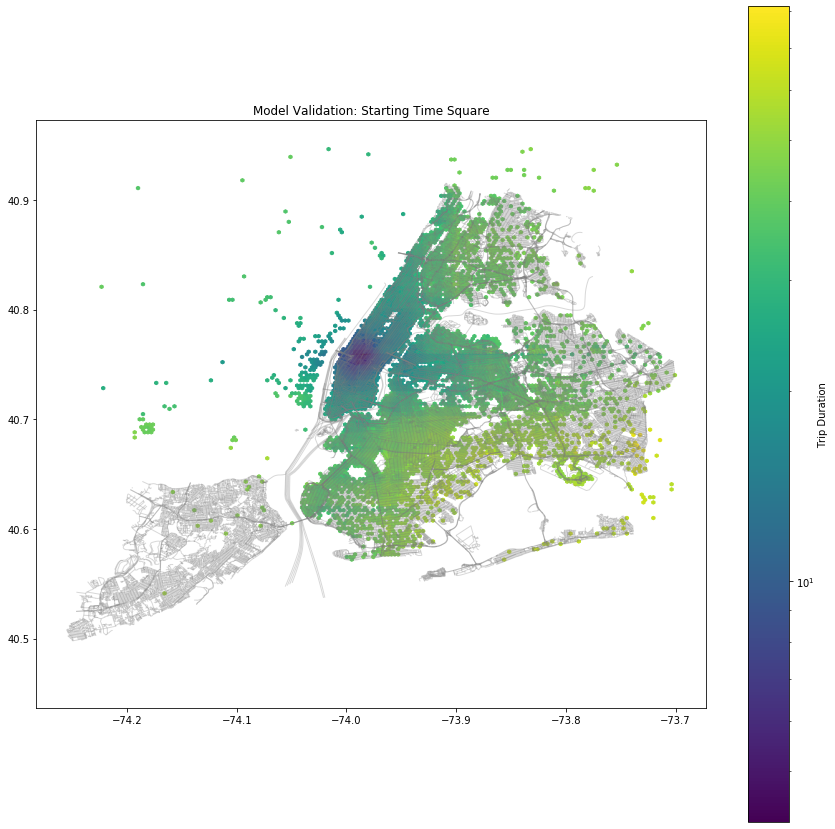

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

#Plotting city streets
street_map.plot(ax = ax, alpha = 0.3, color = 'grey', linewidth=1)

#Plot hexbins
hb = plt.hexbin(plot_dat.dropoff_longitude, 
                plot_dat.dropoff_latitude, 
                bins='log', 
                C = plot_dat.pred_time/60, 
                mincnt=1, 
                gridsize=180)

#Adding key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Trip Duration')

# Title and bounds
ax.set_title('Model Validation: Starting Time Square')

plt.show()

## Function Output Formats

The next step is to create test inputs for the optimization functions to show the different output formats.

In [6]:
test_set

,pickup_longitude,pickup_latitude
0,-73.993599,40.747028
1,-73.863625,40.769852
2,-73.990532,40.751259
3,-73.991287,40.750370
4,-74.014709,40.714329


In [7]:
test_start

,pickup_longitude,pickup_latitude
100,-73.966743,40.764004


In [8]:
test_date

datetime.datetime(2020, 5, 17, 17, 0)

Showing only the last generation:

In [21]:
get_optimal_order(test_start, test_set, test_date, 5, 3)

0:00:01.364882


,0,1,2,3,4,total_time,rank,chance
0,0,4,3,2,1,5412.574860,4.0,0.266667
1,1,0,3,2,4,5815.795197,3.0,0.200000
2,3,0,4,2,1,5323.666885,5.0,0.333333
3,3,2,1,0,4,6534.532547,2.0,0.133333
4,4,0,1,3,2,6968.888443,1.0,0.066667


Showing all iterations:

In [22]:
get_all(test_start, test_set, test_date, 5, 3)

0:00:01.833602


,0,1,2,3,4,total_time,rank,chance,gen
0,2,1,4,3,0,7005.447205,1.0,0.066667,0
1,3,2,0,1,4,6291.260544,4.0,0.266667,0
2,2,1,0,3,4,6616.627930,3.0,0.200000,0
3,2,3,4,0,1,4972.529358,5.0,0.333333,0
4,2,4,1,0,3,6984.792480,2.0,0.133333,0
0,2,1,4,0,3,7020.007324,1.5,0.100000,1
1,2,3,0,1,4,6258.298676,5.0,0.333333,1
2,3,2,4,1,0,7016.963516,3.0,0.200000,1
3,3,2,0,1,4,6291.260544,4.0,0.266667,1
4,2,1,4,0,3,7020.007324,1.5,0.100000,1


# Visualizations / Dashboard Application

All the visulizations and dashboard is done through Bokeh, an interactive visualization library for modern web browsers. It provides elegant, concise construction of versatile graphics, and affords high-performance interactivity over large or streaming datasets. It helps create interactive plots, dashboards, and data applications. Essentially, it converts python to Java, Json, and JavaScript. The dashboard has ways for users to easily input the required parameters to the feature above and produces associated visualizations. Demo video file in github repository.

For more information on bokeh: https://docs.bokeh.org/en/latest/index.html

The elements included:
- Interactive map for users to input points by double clicking
- Date and time input 
- Initial population size and generations input
- Table of inputted points that updates live
- Table that tracks the iterations of the genetic algorithm
- A multi-line graph acting as a time series graph to track the fitness of different sets across generations
- A histogram of the distribution of the sets by the end of the genetic algorithm
- Reset button so users do not have to refresh the page

Additionally, multiple graphs have an incorporated hover feature that provides additional information.

Command line input to run: bokeh serve --show bokeh-ui.py

In [ ]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, \
    Column, \
    Button, \
    DataTable, \
    TableColumn, \
    Row, \
    Slider, \
    DatePicker, \
    TextInput, \
    CustomJS, \
    Div, \
    HoverTool, \
    GeoJSONDataSource, \
    Select
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import Viridis
from bokeh.io import curdoc
from bokeh.events import DoubleTap
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import aux_functions as af
from bokeh.themes import built_in_themes, Theme
import numpy as np
import math
from itertools import cycle
from pyproj import Proj, transform

#holding coordinates for map and plotting
coordList=[]
newcoordList = []

#data sources 
source = ColumnDataSource(pd.DataFrame(data=dict(x=[], y=[])))
ssource = ColumnDataSource(pd.DataFrame(data=dict(x=[], y=[])))
line_source = ColumnDataSource(pd.DataFrame({'latitude' : [], 'longitude' : []}))
initpop = ColumnDataSource(pd.DataFrame({'init_pop' : [10]}))
numgens = ColumnDataSource(pd.DataFrame({'num_gens' : [5]}))
date = ColumnDataSource(pd.DataFrame({'date' : [datetime.today()]}))
hour = ColumnDataSource(pd.DataFrame({'hour' : [8]}))
minute = ColumnDataSource(pd.DataFrame({'minute' : [0]}))
ampm = ColumnDataSource(pd.DataFrame({'ampm' : [0]}))
output = ColumnDataSource(pd.DataFrame({'order' : [], 'total_time' : [], 'chance' : [], 'gen' : []}))
timeseries = ColumnDataSource(pd.DataFrame({'order' : [], 'chance' : [], 'gen' : []}))
data_dict = {'x': [],'y': [], 'color': []}
source_table_hist = ColumnDataSource(data=data_dict)


#color pallete for graphs
palette = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fbff']

#graph base
p = figure(
    toolbar_location="above",
    width=700,
    height=700,
    name = 'base',
    tools = ['tap, wheel_zoom, reset, pan'],
    x_range=(-8210000, -8270000), y_range=(4940000, 5000000),
    x_axis_type="mercator",
    y_axis_type="mercator"
           )

#map tiles
p.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA), name = 'tiles')

p.title.text = "Route Optimizer"
p.title.text_font_size = "25px"
p.xaxis.axis_label = "Longitude"
p.yaxis.axis_label = "Latitude"

#points on map
p.circle_cross(source = source,
               x ='x',
               y ='y',
               size=10,
               fill_alpha=0.2,
               line_width=2,
               name = 'pts'
               )

#hover function
p.add_tools(HoverTool(names=['pts'],
                      show_arrow=False,
                      line_policy='next',
                      tooltips=[("(lon, lat)", "(@conv)"),
                                ("index", "@num"),]
                      )
            )

#histogram
h = figure(x_range=data_dict['x'],
           height = 300,
           width=600,
           tools="hover",
           tooltips="@x: @y",
           title="Combination Counts",
           toolbar_location="above",)

h.vbar(x ='x',
       top ='y',
       width = .7,
       color='color',
       source=source_table_hist)

h.xaxis.major_label_orientation = 1 #math.pi/2
h.xaxis.axis_label = "Order"
h.yaxis.axis_label = "Count"

#time series
l = figure(title="Fitness",
           y_axis_type="linear",
           tools="hover",
           tooltips="@name",
           plot_height = 300,
           width=600,
           toolbar_location="above")

l.xaxis.axis_label = 'Generation'
l.yaxis.axis_label = 'Fitness'

#add a dot where the click happened
def callback(event):
    Coords=(event.x, event.y)
    coordList.append(Coords)
    newCoords = transform(Proj(init='epsg:3857'),
                          Proj(init='epsg:4326'),
                          event.x,
                          event.y)
    newcoordList.append(newCoords)
    source.data = pd.DataFrame(dict(x=[i[0] for i in coordList],
                                    y=[i[1] for i in coordList],
                                    conv = [(round(i[0],2),round(i[1],2)) for i in newcoordList],
                                    num = [i for i in range(len(newcoordList))]))
    ssource.data = pd.DataFrame(dict(x=[i[0] for i in newcoordList], y=[i[1] for i in newcoordList]))

#main function activated by optimize function
def solve():
    print('start') #check to make sure function is running
    line_source.data = {k: [] for k in line_source.data} #clear graph when rerunning
    
    #prepare inputs
    start_date = pd.DataFrame(date.data)['date'][0]#.to_pydatetime()
    start_hour = int(pd.DataFrame(hour.data)['hour'][0]) + int(pd.DataFrame(ampm.data)['ampm'][0])
    start_minute = int(pd.DataFrame(minute.data)['minute'][0])
    start_date = start_date + timedelta(hours=start_hour) + timedelta(minutes=start_minute)
    init_pop = pd.DataFrame(initpop.data)['init_pop'][0]
    num_gens = pd.DataFrame(numgens.data)['num_gens'][0]
    points_df = pd.DataFrame(newcoordList)
    points_df.columns = ['latitude', 'longitude']
    start_loc = pd.DataFrame(points_df.loc[0]).transpose()
    visit_points = points_df.loc[1:].reset_index()[['latitude', 'longitude']]

    #running the optimization function
    hold = af.get_all(start_loc,
                      visit_points,
                      start_date,
                      init_pop,
                      num_gens)

    hold['chance'] = round(hold['chance'], 3)

    #source data frame
    combos = hold.iloc[0:, :len(hold.columns) - 4]
    a = combos.columns
    hold['order'] = '0->' + combos[a].apply(lambda row: '->'.join((row.values+1).astype(str)), axis=1)

    # table data updates
    table_data = hold.groupby(['order', 'total_time', 'gen']).sum().reset_index()
    table_data = table_data.sort_values(['gen', 'chance'], ascending=[False, False])
    output.data = table_data[['order', 'total_time', 'chance', 'gen']]

    #line plotting update
    plot_order = af.condense(hold.tail(init_pop)).sort_values('total_time').iloc[0, 0:len(hold.columns) - 5]
    full_plot_order = [0] + list(plot_order + 1)
    ordered_points = pd.DataFrame(source.data)
    ordered_points = ordered_points.reindex(full_plot_order).reset_index(drop=True)
    line_source.data = ordered_points
    p.line(x = 'x',
           y = 'y',
           line_width = 2,
           color = '#6baed6',
           name = 'line',
           source = line_source)

    #histogram data update
    hist_data = hold.groupby('order').count().reset_index()
    color_hold = []
    colors = cycle(palette)
    for i, color in zip(range(len(hist_data)), colors):
        color_hold.append(color)
    groups = list(hist_data['order'])
    count = list(hist_data['gen'])
    data_dict = {'x': groups, 'y': count, 'color': color_hold}
    h.x_range.factors = data_dict['x']  # update existing range (good)
    source_table_hist.data = data_dict

    #line graph / time series update
    line_data = hold.groupby(['order', 'gen']).sum().reset_index()[['order', 'gen', 'chance']]
    line_data = line_data.groupby('order').apply(lambda x: [list(x['chance']), list(x['gen'])]).apply(pd.Series).reset_index()
    line_data.columns = ['order', 'chance', 'gen']
    line_data['color'] = color_hold
    timeseries.data = line_data
    l.multi_line(xs ='gen',
                 ys ='chance',
                 # legend = 'order',
                 line_width=4,
                 line_alpha=0.6,
                 hover_line_alpha=1.0,
                 color = 'color',
                 source = timeseries)
    l.legend.location = 'top_left'
    l.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('order:','@order')
    ]))
    print('finished')


#population size update
def update_popsize(attr, old, new):
    initpop.data = pd.DataFrame({'init_pop' : [new]})

#generation update
def update_numgen(attr, old, new):
    numgens.data = pd.DataFrame({'num_gens' : [new]})

#date update
def update_date(attr, old, new):
    date.data = pd.DataFrame({'date': [new]})

#hour update
def update_hour(attr, old, new):
    hour.data = pd.DataFrame({'hour': [int(new)]})

#minute update
def update_minute(attr, old, new):
    minute.data = pd.DataFrame({'minute': [int(new)]})

#ampm update
def update_ampm(attr, old, new):
    if new == 'PM':
        ampm.data = pd.DataFrame({'ampm': [12]})
    else :
        ampm.data = pd.DataFrame({'ampm': [0]})

#reset
def clear():
    global coordList
    global newcoordList
    source.data = {k: [] for k in source.data}
    ssource.data = {k: [] for k in ssource.data}
    coordList = []
    newcoordList = []
    line_source.data = {k: [] for k in line_source.data}

#data table
columns = [
        TableColumn(field='x', title='longitude'),
        TableColumn(field='y', title='latitude')
    ]
data_table = DataTable(source=ssource,
                       columns=columns,
                       width=600,
                       height=150)

columns2 = [
        TableColumn(field='order', title='order'),
        TableColumn(field='total_time', title='total time'),
        TableColumn(field='chance', title='chance'),
        TableColumn(field='gen', title='gen')
    ]

data_table_2 = DataTable(source=output,
                         columns=columns2,
                         width=700,
                         height=280)

#double click on map
p.on_event(DoubleTap, callback)

#optimizer button
button = Button(label="Optimize",
                button_type="primary",
                width = 600
                )
button.on_click(solve)

#reset button
reset = Button(label="Reset",
               button_type="default",
               width = 90
               )
reset.on_click(clear)

#dropdown choices
select_hour = Select(title="Hour:",
                     value="8",
                     options=["1", "2", "3", "4", "5", "6",
                                                   "7", "8", "9", "10", "11", "12"],
                     width = 85)
select_hour.on_change('value', update_hour)

select_minute = Select(title="Minute:",
                       value="00",
                       options=["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                                                        "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
                                                        "21", "22", "23", "24", "25", "26", "27", "28", "29", "30",
                                                        "31", "32", "33", "34", "35", "36", "37", "38", "39", "40",
                                                        "41", "42", "43", "44", "45", "46", "47", "48", "49", "50",
                                                        "51", "52", "53", "54", "55", "56", "57", "58", "59"],
                       width = 85)
select_minute.on_change('value', update_minute)

select_ampm = Select(title="AM/PM:",
                     value="00",
                     options=["AM", "PM"],
                     width = 85)
select_ampm.on_change('value', update_ampm)

#sliders
#populat
population_size_input = Slider(start = 5,
                               end = 100,
                               value=15,
                               step=1,
                               width = 600,
                               title="Population Size")
population_size_input.on_change('value', update_popsize)

generation_input = Slider(start = 2,
                          end = 100,
                          value=10,
                          step=1,
                          width = 600,
                          title="Number of Generations")
generation_input.on_change('value', update_numgen)

#date picker 
dt_pckr = DatePicker(title='Start Date',
                     min_date=datetime(1900,1,1),
                     max_date=datetime.today().replace(year = datetime.today().year + 5),
                     width = 310)
dt_pckr.on_change('value', update_date)

#table titles
table1_title = Div(text="""<b>Inputted Locations</b>""")
table2_title = Div(text="""<b>History</b>""")
table2_title = Div(text="""<b>History</b>""")

#layour
layout = Row(Column(p,
                    Row(button, reset),
                    table2_title,
                    data_table_2,
                    ),
             Column(
                    Row(dt_pckr, select_hour, select_minute, select_ampm),
                    population_size_input,
                    generation_input,
                    table1_title,
                    data_table,
                    l,
                    h
                    )
            )

curdoc().add_root(layout)

The visualization / dashboard went through several phases seen below. The most major change would be the graph tiles. Initially I was using the shape file which contained information on the streets. This allowed for more highlighting features, but significantly slowed down the tool because the shape file was so large and contained a lot of information. I replaced the shape file with tiles sourced from carto. To make the tiles work with my model, I had to convert the input locations from mercator to longitude and latitude then convert it back to mercator when plotting on the map.

## Dashboard v1

<img src="image/Route_Optimizer.png">

## Dashboard v2

<img src="image/Route_Optimizer_Update.png">